# Credit Model

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

from pandas.tseries.offsets import *
pd.set_option('display.max_columns', 500)

from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [2]:
df = pd.read_excel('2007_2011.xlsx')

# Data Cleaning

In [3]:
df = df.dropna(thresh=df.shape[0]*0.5,how='all',axis=1)
columns_after_drop = len(df.columns.to_list())

In [4]:
del df['emp_title']
del df['desc']

In [5]:
#Removing all rows that are missing any data                 
df = df.dropna(how='any',axis=0)
df.reset_index(inplace=True)
del df['index']

In [6]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag
0,5000.0,5000.0,4975.0,36 months,0.1065,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,0.837,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,2015-01-01,171.62,2017-11-01,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
1,2500.0,2500.0,2500.0,60 months,0.1527,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,0.094,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,2013-04-01,119.66,2016-10-01,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
2,2400.0,2400.0,2400.0,36 months,0.1596,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,0.985,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,2014-06-01,649.91,2017-06-01,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
3,10000.0,10000.0,10000.0,36 months,0.1349,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,0.210,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,2015-01-01,357.48,2016-04-01,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N
4,3000.0,3000.0,3000.0,60 months,0.1269,67.79,B,B5,1 year,RENT,80000.0,Source Verified,2011-12-01,Fully Paid,n,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,0.539,38.0,f,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,2017-01-01,67.30,2017-01-01,0.0,1.0,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N


# Dependent Variable: Defaults

In [7]:
df['loan_status'].value_counts()

Fully Paid                                             32646
Charged Off                                             5242
Does not meet the credit policy. Status:Fully Paid      1506
Does not meet the credit policy. Status:Charged Off      518
Name: loan_status, dtype: int64

In [8]:
df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 
                             'Fully Paid', df['loan_status'])

In [9]:
df['loan_status'] = np.where(df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 
                             'Charged Off', df['loan_status'])

In [10]:
df['loan_status'] = np.where(df['loan_status'] == 'Charged Off', 1, 0)
df['loan_status'] = df['loan_status'].astype(float)

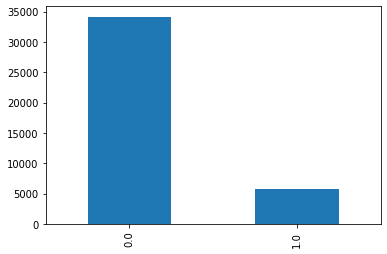

In [11]:
df['loan_status'].value_counts().plot.bar()

In [12]:
print('Proportion of the classes in the data:')
print(round(df['loan_status'].value_counts() / len(df), 2))

Proportion of the classes in the data:
0.0    0.86
1.0    0.14
Name: loan_status, dtype: float64


# Independent Variables

In [13]:
df['verification_status'].value_counts()

Not Verified       16869
Verified           12967
Source Verified    10076
Name: verification_status, dtype: int64

In [14]:
df['verification_status'] = np.where(df['verification_status'] == 'Source Verified', 'Verified', df['verification_status'])
df['verification_status'] = np.where(df['verification_status'] == 'Verified', 1, 0)

In [15]:
df['credit_history_length'] = round((df['issue_d'] - df['earliest_cr_line']) / np.timedelta64(1, 'Y'), 1)

In [16]:
X = df[['dti', 'delinq_2yrs', 'credit_history_length', 'inq_last_6mths', 'pub_rec', 
        'revol_util', 'verification_status']]

y = df['loan_status']

In [17]:
X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,dti,delinq_2yrs,credit_history_length,inq_last_6mths,pub_rec,revol_util,verification_status
dti,1.00,-0.04,0.06,0.02,-0.00,0.28,0.03
delinq_2yrs,-0.04,1.00,0.07,0.02,0.01,-0.05,0.01
credit_history_length,0.06,0.07,1.00,-0.02,0.05,-0.02,0.06
inq_last_6mths,0.02,0.02,-0.02,1.00,0.06,-0.05,-0.02
pub_rec,-0.00,0.01,0.05,0.06,1.00,0.06,-0.02
revol_util,0.28,-0.05,-0.02,-0.05,0.06,1.00,0.05
verification_status,0.03,0.01,0.06,-0.02,-0.02,0.05,1.00


# Train/Test Split

In [18]:
# Splitting into training and testing datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2, shuffle = True, stratify = y)

# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
clf = LogisticRegression(max_iter=100000, solver = 'lbfgs')

In [20]:
# fit the model
clf.fit(X_train, y_train.ravel())

# prediction for training dataset
train_pred = clf.predict(X_train)

# prediction for testing dataset
test_pred = clf.predict(X_test)

# actual probabilities
test_pred_probs = clf.predict_proba(X_test)[:,1]

In [21]:
import statsmodels.api as sm

X1 = sm.add_constant(X)

logit_model = sm.Logit(y, X1)

result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.400813
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                39912
Model:                          Logit   Df Residuals:                    39904
Method:                           MLE   Df Model:                            7
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                 0.02886
Time:                        21:26:31   Log-Likelihood:                -15997.
converged:                       True   LL-Null:                       -16473.
Covariance Type:            nonrobust   LLR p-value:                5.031e-201
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.6685      0.054    -49.514      0.000      -2.774      -2.563
dti                       0.0081      0.002      3.553      0.000       0.004       0.013
delinq_2yrs               0.1221      0.027      4.605      0.000       0.070       0.174
credit_history_length    -0.0099      0.002     -4.391      0.000      -0.014      -0.006
inq_last_6mths            0.1853      0.009     20.220      0.000       0.167       0.203
pub_rec                   0.4338      0.051      8.506      0.000       0.334       0.534
revol_util                0.9828      0.054     18.085      0.000       0.876       1.089
verification_status       0.2254      0.030      7.560      0.000       0.167       0.284
=========================================================================================
"""

# Accruacy - No Optimal Cutoff

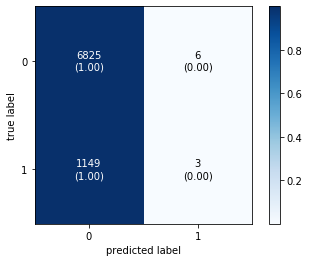

In [22]:
cm = confusion_matrix(y_test, test_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

# Optimal Cutoff

In [23]:
def Find_Optimal_Cutoff(y_test, test_pred_probs):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred_probs)
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf': pd.Series(tpr-(1-fpr), index=i), 'threshold': pd.Series(thresholds, index=i)})
    roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
    return list(roc_t['threshold'])

In [24]:
threshold = Find_Optimal_Cutoff(y_test, test_pred_probs)
print(threshold)

[0.1443528433024836]


# Confusion Matrix Using Optimal Cutoff

In [25]:
# fit the model
clf.fit(X_train, y_train.ravel())

# prediction for testing dataset
test_pred = (clf.predict_proba(X_test)[:,1] >= threshold).astype(bool)

# actual probabilities
test_pred_probs = clf.predict_proba(X_test)[:,1]

train_pred_probs = clf.predict_proba(X_train)[:,1]

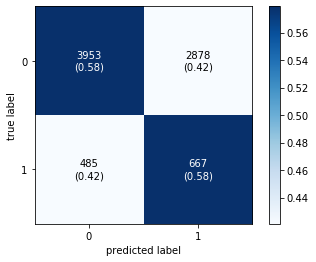

In [26]:
cm = confusion_matrix(y_test, test_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, show_normed=True, colorbar=True)
plt.show()

In [27]:
fpr, tpr, threshold = metrics.roc_curve(y_test, test_pred_probs)
roc_auc = auc(fpr, tpr)

In [28]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.show()

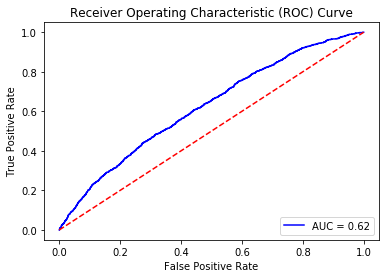

In [29]:
plot_roc_curve(fpr, tpr)